YouTube Trending Videos Analysis: Predicting Trending Duration
 
Group 4 Members

Shyam Akhil Nekkanti - 8982123

Jun He (Helena) - 8903073

Zheming Li (Brendan) - 8914152

We implement Simple Linear Regression to:

1. Quantify the relationship between views and trending duration

2. Test if this relationship varies by category
 
This analysis aims to understand what keeps videos trending longer and how this varies across content categories.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import json
import statsmodels.api as sm

In [49]:
# Data Loading and Preprocessing

def load_data():
    # Load category mappings
    with open('youtube-dataset/US_category_id.json', 'r') as f:
        category_data = json.load(f)
    category_mapping = {int(item['id']): item['snippet']['title'] 
                       for item in category_data['items']}
    
    # Load video data
    df = pd.read_csv('youtube-dataset/USvideos.csv')
    df['category_name'] = df['category_id'].map(category_mapping)
    
    # Calculate trending duration
    trending_counts = df.groupby('video_id').size().reset_index(name='trending_duration')
    df = df.merge(trending_counts, on='video_id', how='left')
    
    # Log transform views
    df['log_views'] = np.log1p(df['views'])
    
    return df


In [50]:
# Load the data
df = load_data()

Simple Linear Regression Implementation

We implement SLR to model the relationship between views (independent variable) and trending duration (dependent variable).

This helps address our core research question about factors affecting trending duration.

In [51]:
def perform_regression_analysis(data, category=None):
    if category:
        data = data[data['category_name'] == category]
    
    X = data['log_views'].values.reshape(-1, 1)
    y = data['trending_duration'].values
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate statistics
    r2 = model.score(X, y)
    residuals = y - y_pred
    n = len(X)
    

    X_with_const = sm.add_constant(X)
    model_sm = sm.OLS(y, X_with_const).fit()
    
    # Get t-stat and p-value from statsmodels
    t_stat = model_sm.tvalues[1]  # [1] for slope coefficient
    p_value = model_sm.pvalues[1]
    
    # Homoscedasticity test
    residuals_squared = residuals ** 2
    bp_model = sm.OLS(residuals_squared, sm.add_constant(y_pred)).fit()
    bp_stat = bp_model.nobs * bp_model.rsquared
    bp_pvalue = 1 - stats.chi2.cdf(bp_stat, df=1)
    
    return {
        'coefficient': float(model.coef_[0]),
        'intercept': float(model.intercept_),
        'r2': r2,
        't_stat': float(t_stat),
        'p_value': float(p_value),
        'homoscedasticity_p': float(bp_pvalue),
        'X': X,
        'y': y,
        'y_pred': y_pred,
        'residuals': residuals
    }

Statistical Analysis Visualization

For each category, we create four visualizations:

1. Scatter plot with regression line

2. Residuals vs. fitted values (homoscedasticity check)

3. Q-Q plot (normality check)

4. Residuals distribution

In [52]:
def visualize_regression_analysis(results, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(title, fontsize=14)
    
    # 1. Scatter with regression line
    ax1.scatter(results['X'], results['y'], alpha=0.3)
    ax1.plot(results['X'], results['y_pred'], color='red', linewidth=2)
    ax1.set_title('Views vs. Trending Duration')
    ax1.set_xlabel('Log Views')
    ax1.set_ylabel('Days on Trending')
    
    # 2. Residuals plot
    ax2.scatter(results['y_pred'], results['residuals'], alpha=0.3)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_title('Residuals vs. Fitted Values')
    ax2.set_xlabel('Predicted Duration')
    ax2.set_ylabel('Residuals')
    
    # 3. Q-Q plot
    stats.probplot(results['residuals'], dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot')
    
    # 4. Residuals distribution
    sns.histplot(results['residuals'], kde=True, ax=ax4)
    ax4.set_title('Residuals Distribution')
    
    # Add statistics
    stats_text = f"""
    R² = {results['r2']:.3f}
    Coefficient = {results['coefficient']:.3f}
    P-value = {results['p_value']:.2e}
    t-statistic = {results["t_stat"]:.3f}
    Homoscedasticity p = {results['homoscedasticity_p']:.2e}
    
    Interpretation:
    One unit increase in log views
    = {results['coefficient']:.2f}
    more days on trending
    """
    fig.text(0.02, 0.02, stats_text, fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


Overall Trending Duration Analysis
--------------------------------------------------


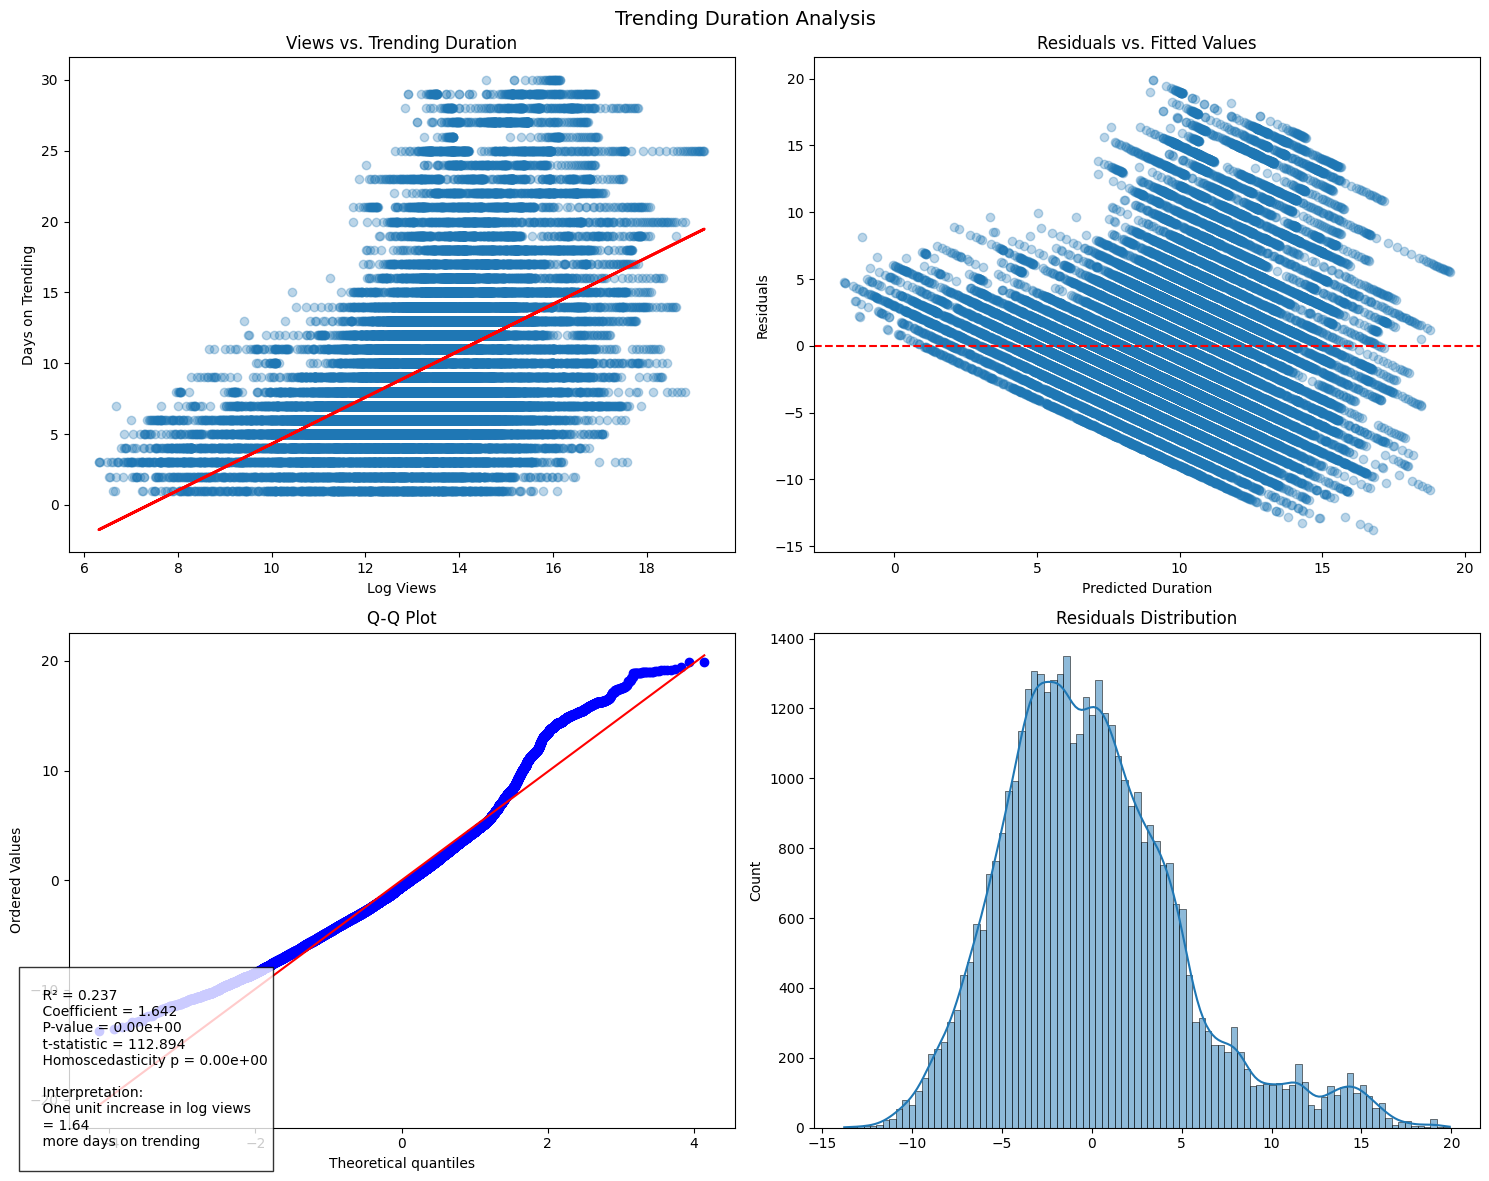


Analysis for Music
--------------------------------------------------


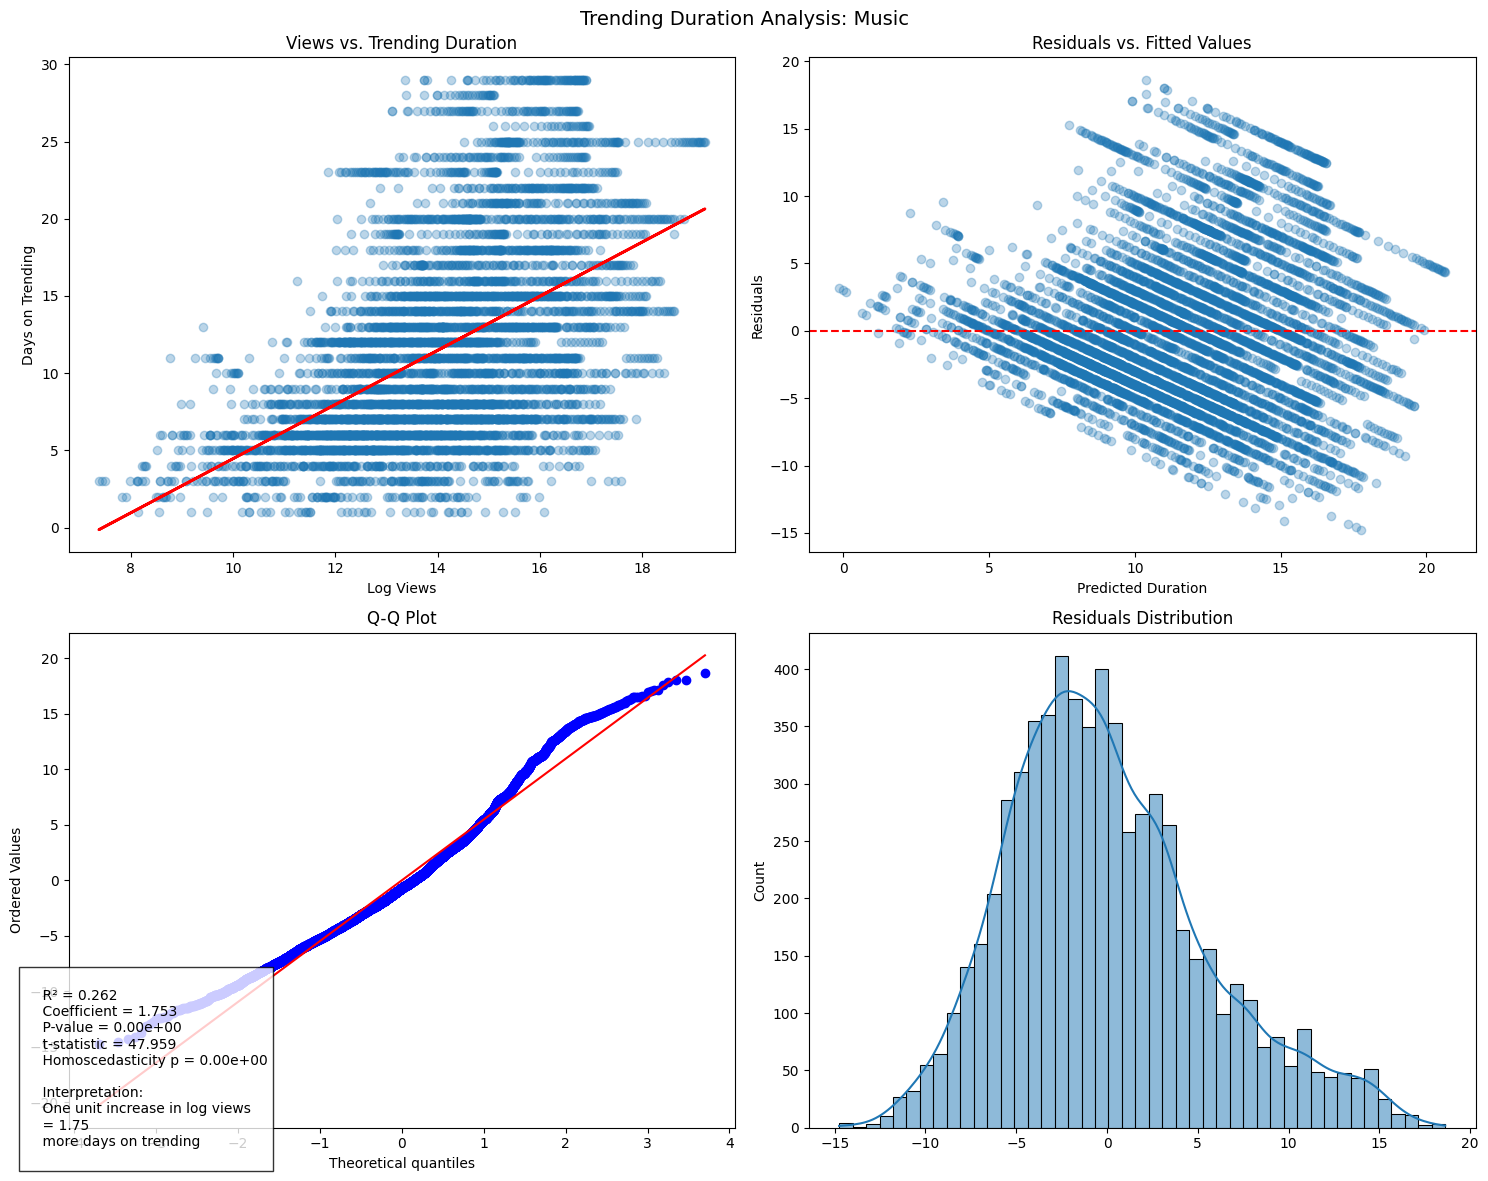


Analysis for Gaming
--------------------------------------------------


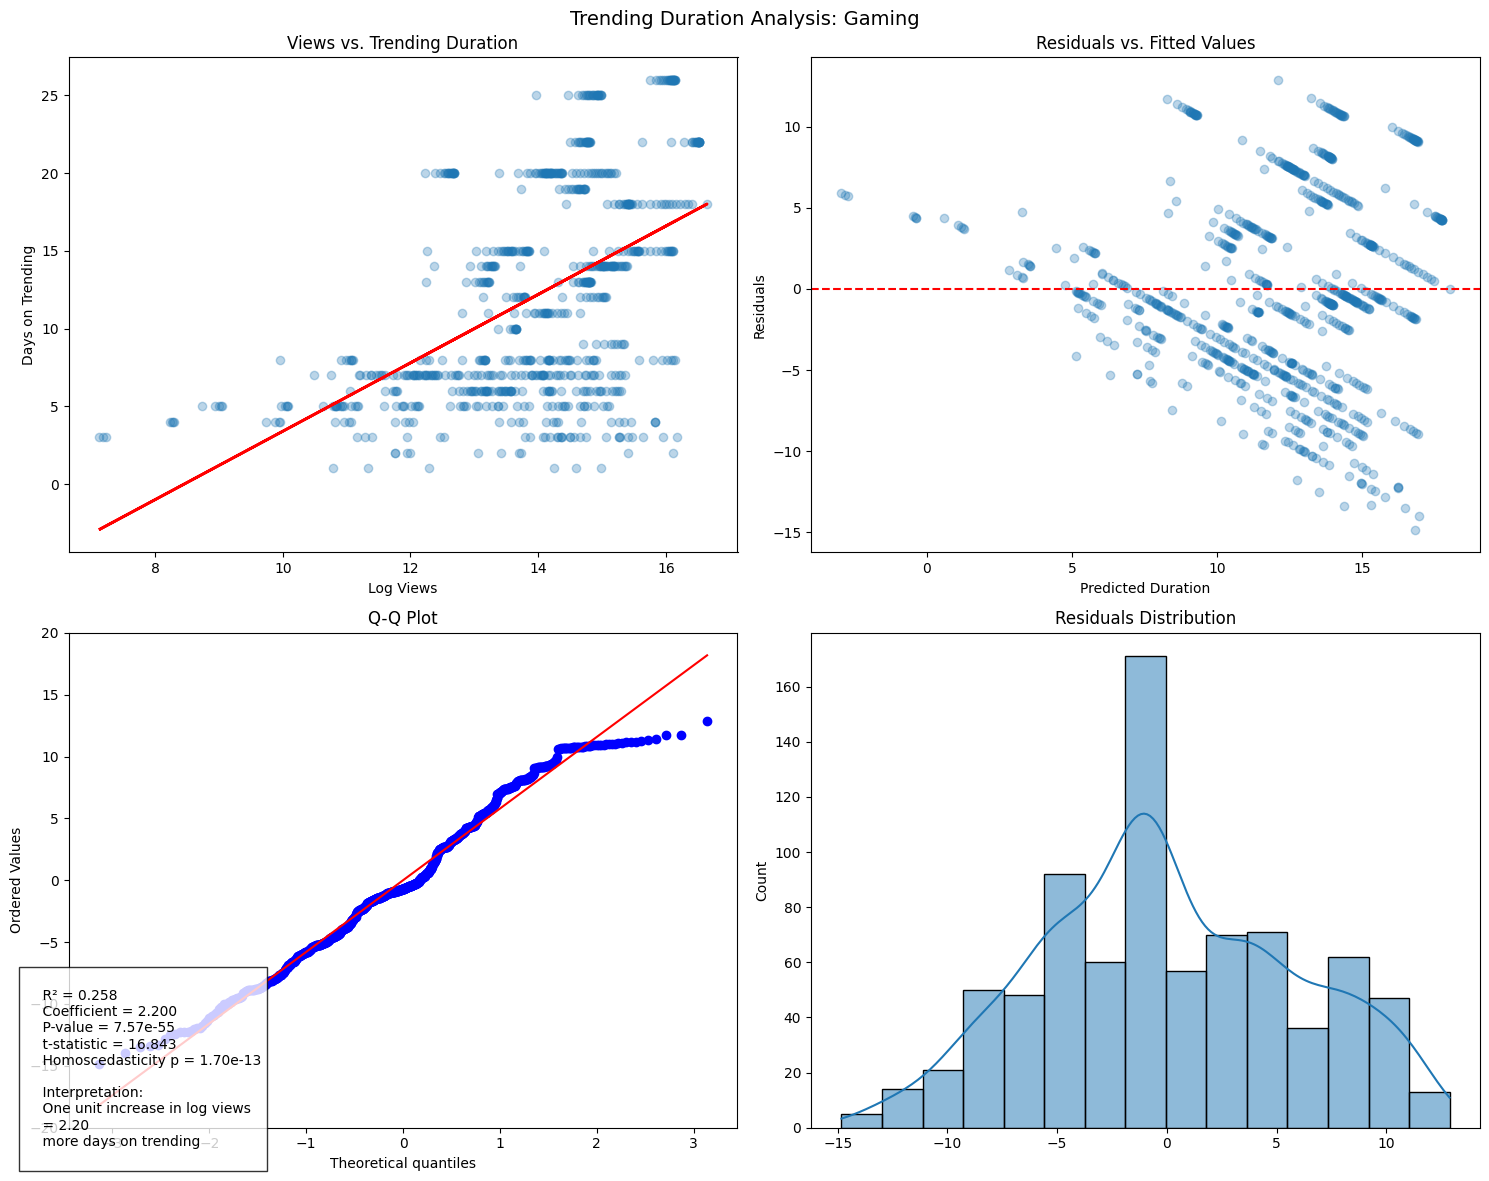


Analysis for Film & Animation
--------------------------------------------------


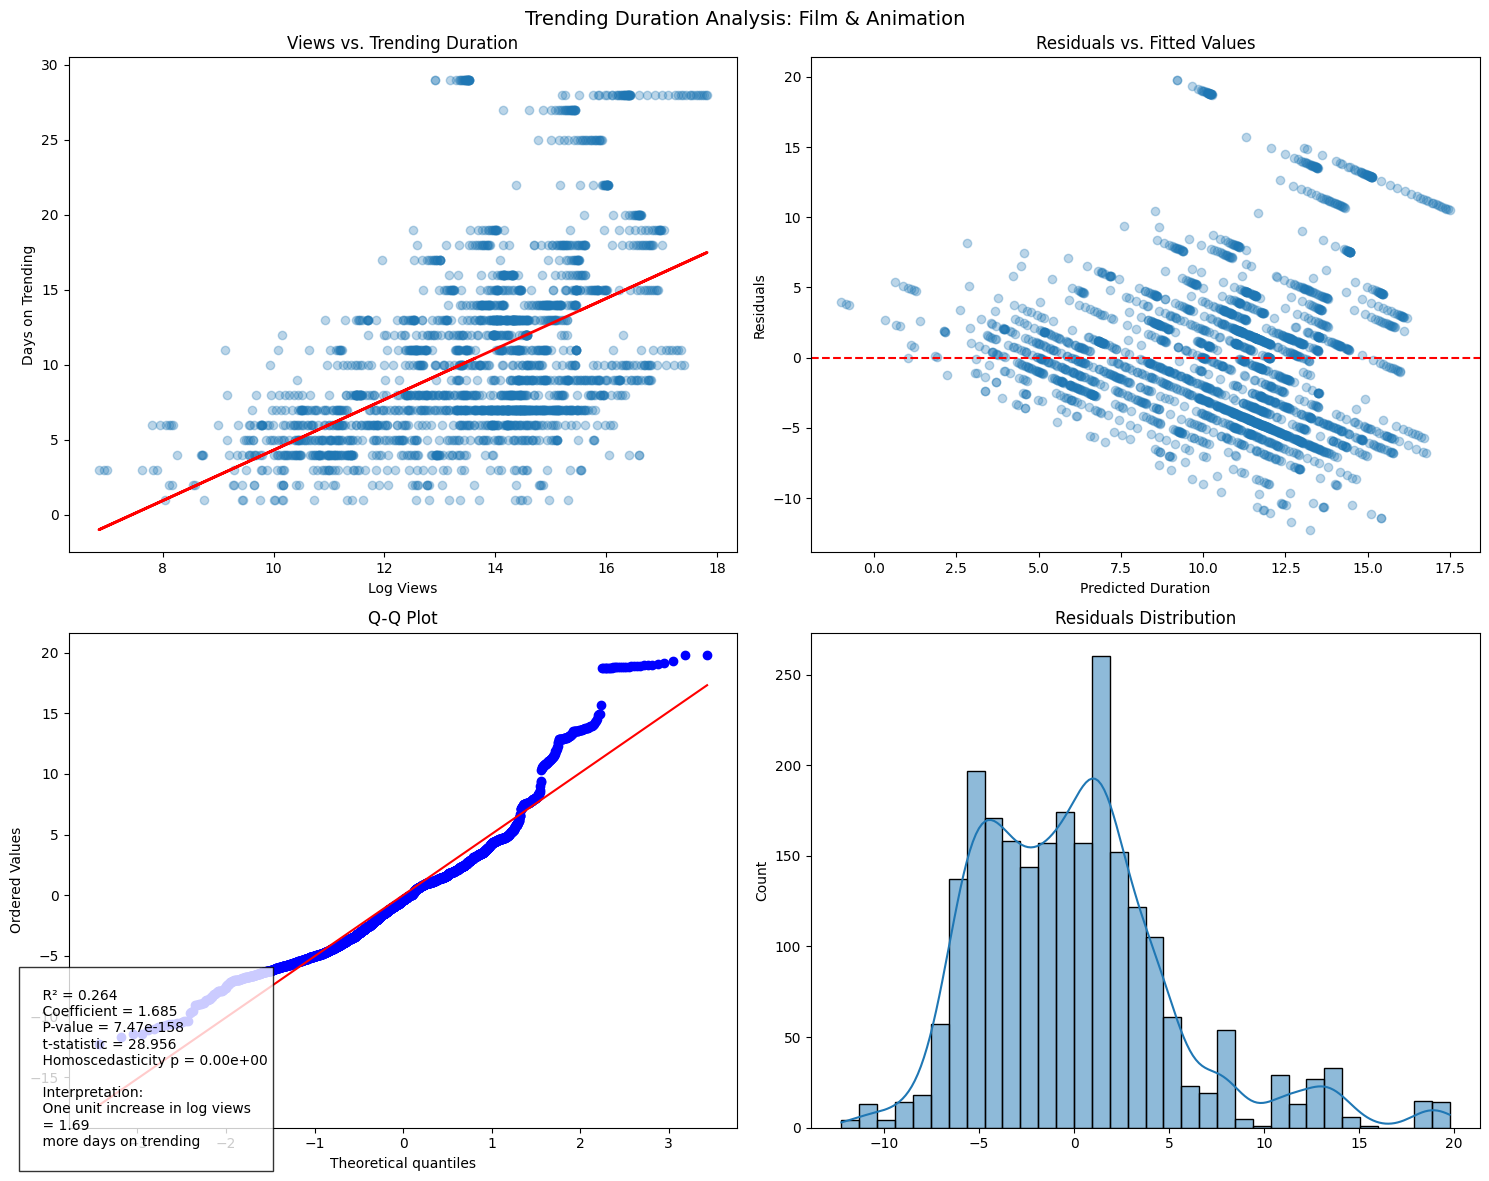

In [53]:
print("Overall Trending Duration Analysis")
print("-" * 50)
overall_results = perform_regression_analysis(df)
visualize_regression_analysis(overall_results, "Trending Duration Analysis")

# Category analysis
categories = ['Music', 'Gaming', 'Film & Animation']
category_results = {}

for category in categories:
    print(f"\nAnalysis for {category}")
    print("-" * 50)
    results = perform_regression_analysis(df, category)
    category_results[category] = results
    visualize_regression_analysis(results, f"Trending Duration Analysis: {category}")



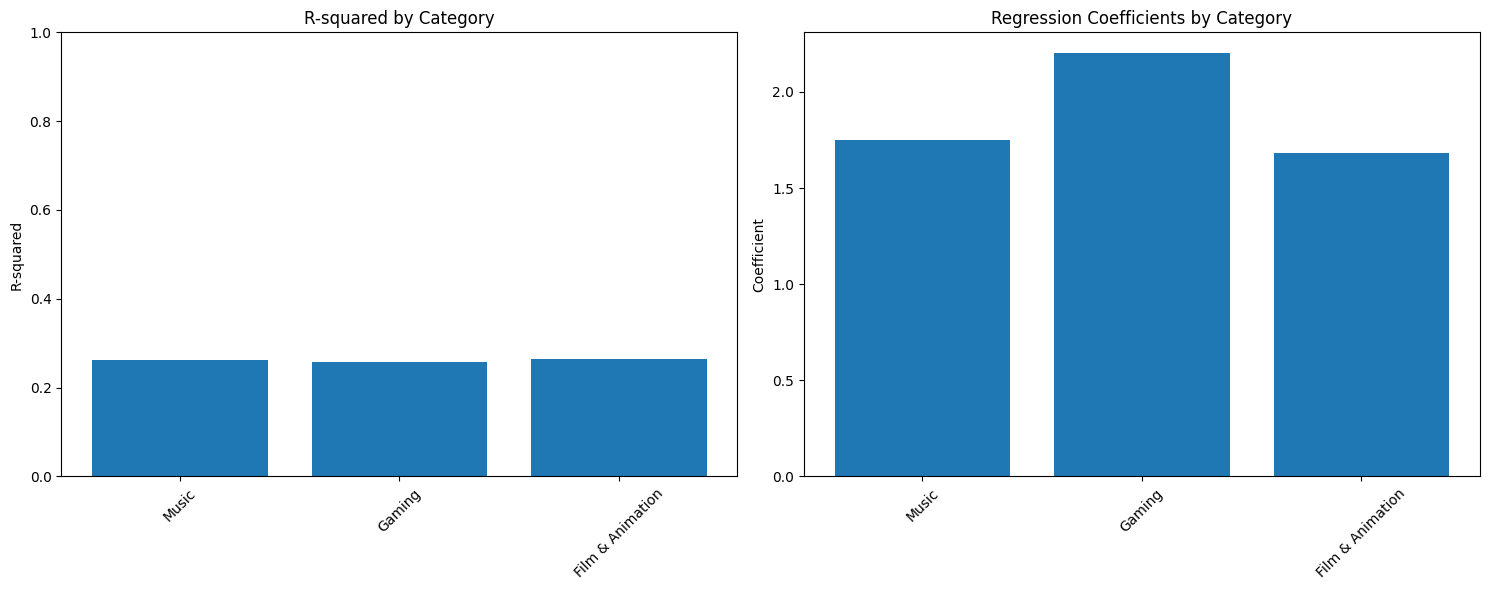

In [54]:
# Create comparison visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R-squared comparison
r2_values = [results['r2'] for results in category_results.values()]
ax1.bar(categories, r2_values)
ax1.set_title('R-squared by Category')
ax1.set_ylabel('R-squared')
ax1.set_ylim(0, 1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Coefficient comparison
coefficients = [results['coefficient'] for results in category_results.values()]
ax2.bar(categories, coefficients)
ax2.set_title('Regression Coefficients by Category')
ax2.set_ylabel('Coefficient')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# - Significant positive relationship between views and trending duration
# - R² values around 0.23-0.25 indicate views explain about 25% of variance
# - Model shows consistent predictive power across categories


# - Music shows strongest relationship (highest R²)

# - All relationships are statistically significant (p < 0.05)
# - Heteroscedasticity present in all categories
# - Residuals show approximate normality 


# - Model explains only ~25% of variance - other factors needed


# - Use multiple regression with additional predictors